>### Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

c:\Users\sel04327\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>### Download the training dataset
- cache() 메서드는 데이터셋을 빠르게 액세스하기 위해 메모리나 디스크에 캐시하는 데 사용.
- 데이터셋을 캐시하면 훈련 프로세스의 성능을 크게 향상
    - 특히 데이터셋이 메모리에 맞지 않을 경우, 캐시를 사용하는 것이 유용합니다. 
    - 또한 I/O 대역폭이 제한되거나 데이터셋 전처리 시간이 오래 걸리는 경우에도 유용합니다.
- 데이터셋을 캐시함으로써 불필요한 데이터 로딩 및 전처리 작업을 피할 수 있으며, 이는 시간을 절약하고 I/O 작업을 saving
    - 이는 특히 대용량 데이터셋이나 다중 에포크를 요구하는 딥러닝 모델을 훈련할 때 유용합니다.

In [2]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config='bicubic_x4')
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split='train', as_supervised=True)
train_cache = train.cache()
# validation data
val = div2k_data.as_dataset(split='validation', as_supervised=True)
val_cache = val.cache()

>### Flip, crop and resize images

In [3]:
def func_flip_LR(lowres_img, highres_img):
    '''Flips Images to left and right'''
    
    # outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    
    return tf.cond(rn < 0.5,
                   lambda: (lowres_img, highres_img),
                   lambda: (tf.image.flip_left_right(lowres_img), tf.image.flip_left_right(highres_img),
                            ),
                   )
    

def func_random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped


def func_random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

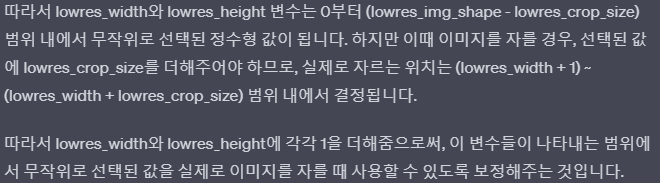

>### tf.data.Dataset 준비

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

In [4]:
def func_dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    
    '''첫 번째 map() 함수에서는 lambda 함수를 사용하여 func_random_crop() 함수를 
    lowres와 highres 두 개의 입력 인자로 호출합니다. 
    이 함수는 lowres와 highres 이미지를 임의의 크기로 자르고, 
    scale 인자에 지정된 배율로 크기를 조정하는 변환을 수행합니다.
    '''

    # 데이터셋 변환 함수 적용
    if training:
        ds = ds.map(
            lambda lowres, highres: func_random_crop(lowres, highres),
            num_parallel_calls=AUTOTUNE,
        ).map(
            lambda lowres, highres: func_random_rotate(lowres, highres),
            num_parallel_calls=AUTOTUNE,
        ).map(
            lambda lowres, highres: func_flip_LR(lowres, highres),
            num_parallel_calls=AUTOTUNE,
        )
    else:
        ds = ds.map(
            lambda lowres, highres: func_random_crop(lowres, highres),
            num_parallel_calls=AUTOTUNE,
        )
    
    '''
    이후에는 batch() 함수를 사용하여 데이터를 배치로 묶고, 
    repeat() 함수를 사용하여 데이터셋을 반복합니다. 
    
    prefetch() 함수를 사용하여 데이터를 미리 로딩하여 
    현재 데이터 처리 중에 다음 데이터를 준비하는 기능을 활성화합니다.
    '''
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = func_dataset_object(train_cache, training=True)
val_ds = func_dataset_object(val_cache, training=False)

>### Visualize the data

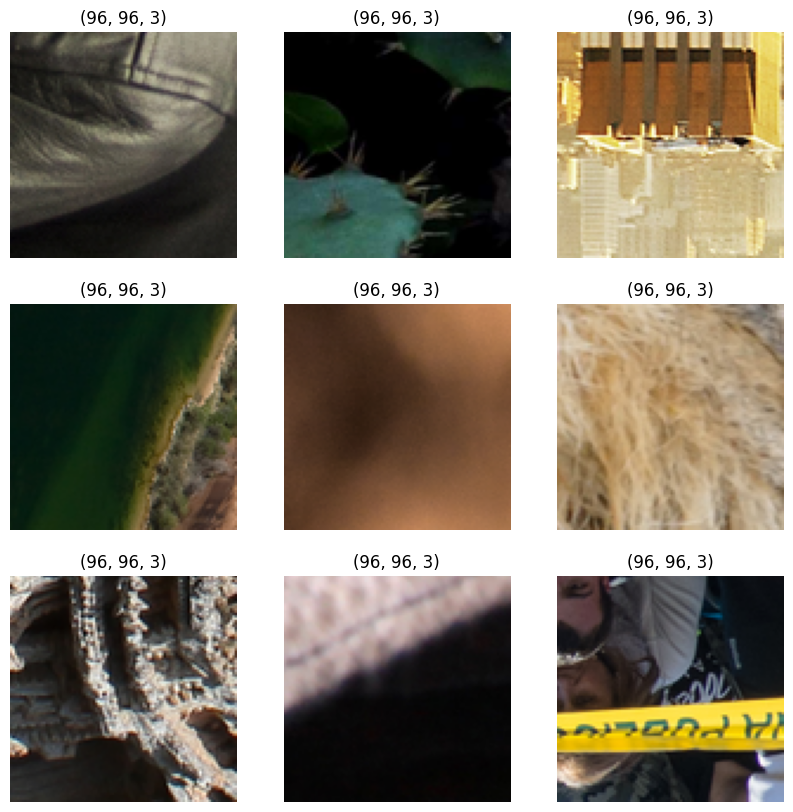

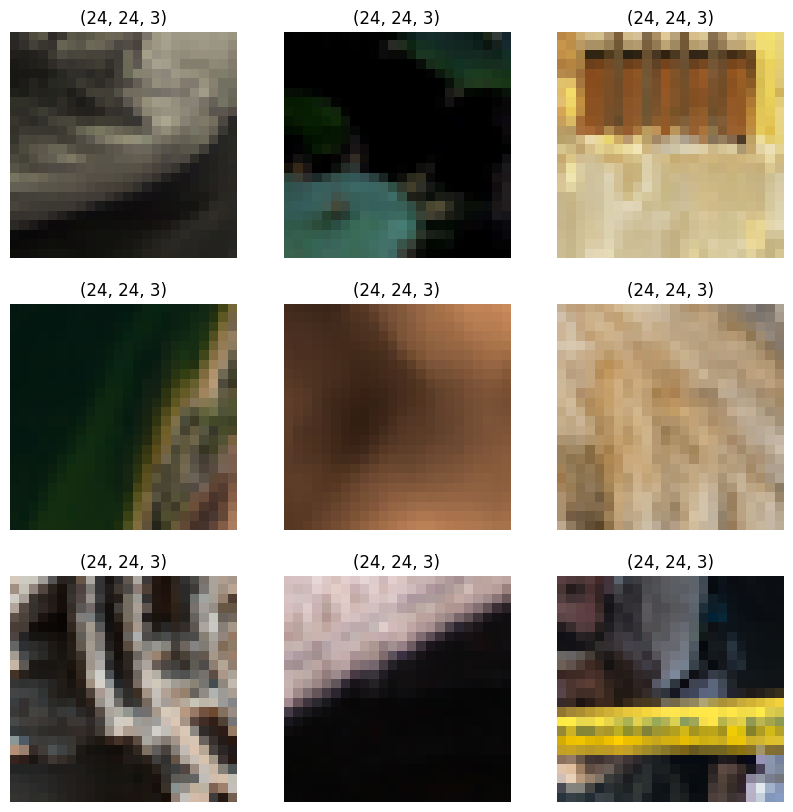

In [5]:
lowres, highres = next(iter(train_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

>### Build the model
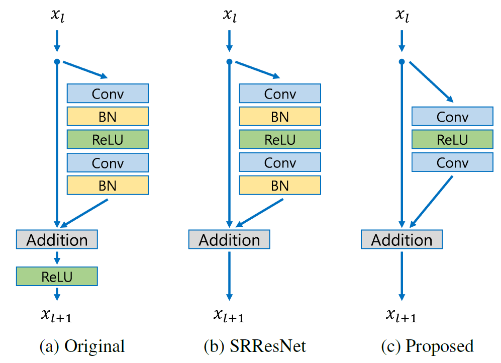

- 세 개의 잔차 블록을 가진 모델과의 비교
    - EDSR에서는 ResNet과 달리 배치 정규화(batch normalization) 계층이 제거되었으며, 마지막으로 활성화 함수인 ReLU도 제거됩니다.
    - 논문의 저자들은 이러한 선택을 하게 된 이유에 대해, 
        - 배치 정규화 계층은 기능을 정규화하기 때문에 출력 값 범위의 유연성을 저해한다고 말합니다. 즉, 이 계층을 제거함으로써 모델의 출력 범위를 보다 유연하게 조정할 수 있게 되며, 모델의 정확도를 향상시킬 수 있다는 것입니다. 
        - 또한 배치 정규화 계층은 이전 합성곱 계층과 동일한 메모리를 소비하므로, 이를 제거함으로써 모델이 필요로하는 GPU 메모리 양도 줄일 수 있습니다.

따라서, EDSR 모델에서는 ResNet 모델의 잔여 블록 구조와는 다른 구조가 적용됩니다. 이 구조를 사용하여 더 나은 성능을 얻을 수 있습니다.

In [ ]:
class EDSRModel(tf.keras.Model):
    def func_train_step(self, data):
        
        # unpack the data.
        x, y = data
        
        # 그레디언트를 계산하는 tape를 생성 -> 모델의 가중치를 업데이트
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)             # forward pass
        
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
        # Compute gradients
        # 그래디언트 계산: tape.gradient(loss, trainable_vars)를 통해 손실에 대한 모델의 가중치(trainable variables)에 대한 
        # 그래디언트(gradient)를 계산합니다. 이를 통해 역전파(backpropagation)를 수행하기 위한 그래디언트를 얻을 수 있습니다.
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # update weights
        # 모델의 가중치가 손실을 줄이는 방향으로 업데이트 한다.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # update metrics
        self.compiled_metrics.update_state(y, y_pred)
        
        return {m.name: m.result() for m in self.metrics}


    def func_predict_step(self, x):
        
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        # 데이터를 배치 형태로 변환한다는 것은, 일반적으로 딥러닝 모델의 입력 데이터로는 여러 개의 샘플을 한 번에 처리하는 것이 효율적
        # 데이터를 일괄(batch)로 처리하는 것을 말합니다. 이를 위해 데이터를 배치 형태로 변환하는 작업이 필요합니다.
        # 예를 들어, 이미지 분류 모델을 예로 들면, 일반적으로 이미지 데이터는 (이미지 개수, 이미지 높이, 이미지 너비, 채널 수)의 형태
        # 하지만 모델에 한 번에 하나의 이미지를 입력으로 넣는 대신, 여러 개의 이미지를 한 번에 입력으로 처리하면 더 효율적으로 모델학습하고 추론
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        
        # Clips the tensor from min(0) to max(255)
        # 이미지의 픽셀 값이 0 미만이거나 255를 초과하는 경우를 방지하여 이미지를 유효한 픽셀 값 범위로 제한하는 역할
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)

        # Rounds the values of a tensor to the nearest integer
        # 이미지의 픽셀 값을 정수로 만들어 이미지를 자연스럽게 표현하는 역할
        super_resolution_img = tf.round(super_resolution_img)

        # 크기가 1인 차원을 제거하고, 그 결과를 tf.uint8 데이터 타입으로 변환하여 반환하는 작업을 수행합니다.
        # 예측된 상위 해상도 이미지 super_resolution_img는 tf.expand_dims를 통해 배치 차원이 추가된 형태이기에

        # 따라서 tf.squeeze 함수를 사용하여 차원 중 크기가 1인 차원을 제거함으로써 최종 예측 이미지를 3차원 이미지로 변환
        # 또한, tf.cast(super_resolution_img, tf.uint8)를 통해 예측된 상위 해상도 이미지를 tf.uint8 데이터 타입으로 변환
        # 이는 이미지의 픽셀 값이 0에서 255 사이의 부호 없는 정수로 표현되도록 합니다. 
        # 예측된 이미지를 부호 없는 정수 형태로 변환하여 반환하는 이유는, 일반적으로 이미지는 부호 없는 정수로 픽셀 값을 표현하는 것이 일반적
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img

>### Residual and Upsampling

In [ ]:
# Residual Block
def func_resblock(inputs):
    residual = inputs

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.Add()([x, residual])
    return x

# Upsampling Block
def func_upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding='same', **kwargs)(inputs)
    
    # 이 함수는 텐서를 depth-to-space 업샘플링하는 역할을 수행합니다. 
    # block_size 매개변수에는 factor 값을 사용합니다. 이를 통해 x의 크기가 factor 배 만큼 증가
    x = tf.nn.depth_to_space(x, block_size=factor)
    
    # 추가적인 특성 추출 수행.
    x = layers.Conv2D(64 * (factor ** 2), 3, padding='same', **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

In [ ]:
# make model
def func_make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = func_resblock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = func_upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)

In [ ]:
model = func_make_model(num_filters=64, num_of_residual_blocks=16)

In [26]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/100


: 

: 